# Demonstration of analog amplitude modulation and demodulation principles

This demo is supposed to shed some light on the principles of [amplitude modulation (AM)](https://en.wikipedia.org/wiki/Amplitude_modulation) and demodulation. 

This demo is written by [Markus Nölle](https://www.htw-berlin.de/hochschule/personen/person/?eid=9586) for a basic course on communications engineering hold at the [university of applied sciences, Berlin](https://www.htw-berlin.de/).

## Import libraries and set defaults

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import ipywidgets as widgets

import helpers

plt.style.use('noelle.mplstyle')

## General parameters

Basic parameters like sample rate, time axis and frequency axis are defined.

In [2]:
sr = 1e3
t = helpers.gen_time_axis(sr, T=1)
f = np.fft.fftshift(np.fft.fftfreq(np.size(t), 1/sr))

---

## Modulation

### Generation of the information signal

An examplary information signal (also known as [baseband signal](https://en.wikipedia.org/wiki/Baseband) ) is generated. Further, this signal $x(t)$ and its corresponding [amplitude spectrum](https://en.wikipedia.org/wiki/Spectral_density#Explanation) $|X(jf)|$ is plotted.

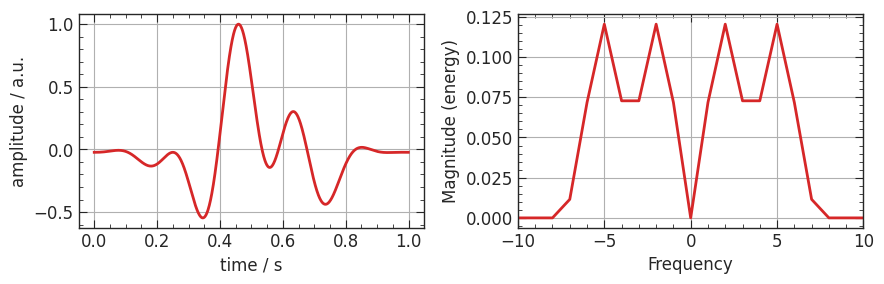

In [3]:
f1 = 5.
f2 = 2.
x = (np.sin(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)) * np.blackman(t.size)
x -= np.mean(x)
x /= np.max(np.abs(x))


n_row = 1
n_col = 2
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
ax.plot(t, x, 'C3');
ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 2)
ax.magnitude_spectrum(x, window=np.ones(x.size), sides="twosided", Fs=sr, scale="linear", pad_to=x.size, color='C3'); # scale="dB" or "linear"
ax.set_xlim(-10, 10);

plt.tight_layout()

### Generation of the carrier signal

A [carrier signal](https://en.wikipedia.org/wiki/Carrier_wave) with a specified carrier frequency is generated. Further, this signal $c(t)$ and its corresponding [amplitude spectrum](https://en.wikipedia.org/wiki/Spectral_density#Explanation) $|C(jf)|$ is plotted.

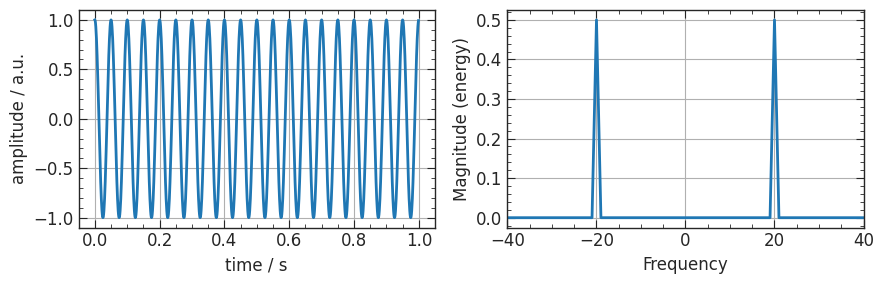

In [4]:
fc = 20 # carrier frequency

c = np.cos(2 * np.pi * fc * t)

n_row = 1
n_col = 2
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
ax.plot(t, c);
ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 2)
ax.magnitude_spectrum(c, window=np.ones(c.size), sides="twosided", Fs=sr, scale="linear"); # scale="dB" or "linear"
ax.set_xlim(-2*fc, 2*fc)

plt.tight_layout()

### Actual amplitude modulation

The information signal is added to a constant signal $a_c$ in order to create an offset
$$ a(t)=a_c+x(t).$$

This resulting signal and the carrier signal are multiplied, resulting in an amplitude modulated signal (also known as [bandpass signal](https://en.wikipedia.org/wiki/Passband))
$$
\begin{eqnarray}
x_{AM}(t) &=& a(t)\cdot cos(\omega_ct+\phi_c) \\
 &=& (a_c+x(t)) \cdot cos(\omega_ct+\phi_c)\\
 &=& a_c \cdot cos(\omega_ct+\phi_c) + x(t) \cdot cos(\omega_ct+\phi_c).
\end{eqnarray}
$$
The ratio between the maximum amplitude of the information signal and the offset $a_c$ is called [modulation index](https://en.wikipedia.org/wiki/Amplitude_modulation#Modulation_index) 
$$
m=\frac{\text{max}(|x(t)|)}{a_c}.
$$
In this section an amplitude modulated signal $x_{AM}(t)$ with variable modulation index (m) can be generated.

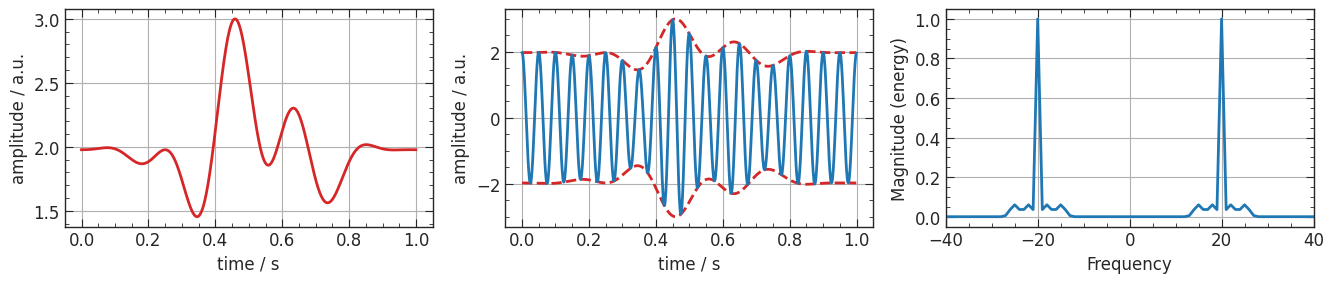

In [5]:
m = 0.5 # modulation index

maxx = np.max(np.abs(x))
a = maxx/m
x_am = a + x

x_am_bp = x_am * c

n_row = 1
n_col = 3
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
ax.plot(t, x_am ,'C3');
ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 2)
ax.plot(t, x_am ,'--C3', t, -x_am, '--C3', t, x_am_bp);
ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 3)
ax.magnitude_spectrum(x_am_bp, window=np.ones(x_am_bp.size), sides="twosided", Fs=sr, scale="linear"); # scale="dB" or "linear"
ax.set_xlim(-2*fc, 2*fc)

plt.tight_layout()

---

## Demodulation

[Demodulation](https://en.wikipedia.org/wiki/Demodulation) is a process which recovers the baseband signal from the bandpass signal by shifting the signals frequency range back to its original location. There are multiple ways to demodulate an amplitude modulated signal. Two of them, namely [envelope detection](https://en.wikipedia.org/wiki/Envelope_detector) and [synchronous detection](https://en.wikipedia.org/wiki/Synchronous_detector), are further discussed below.

### Envolope detection

A setup of an [envelope detector](https://en.wikipedia.org/wiki/Envelope_detector) is depicted below.

![image of an envelope detector](https://upload.wikimedia.org/wikipedia/commons/6/6c/Simple_envelope_detector.svg) 

It consists of a [nonlinear device](https://en.wikipedia.org/wiki/Nonlinear_system), either a [diode](https://en.wikipedia.org/wiki/Diode) or a device which produces the squared input signal at its output, thereby generating new frequency components. Some of the newly generated frequency components exactly fall into the baseband and can afterwards be isolated with a following [lowpass filter](https://en.wikipedia.org/wiki/Low-pass_filter). 

Normally an additional [DC block](https://en.wikipedia.org/wiki/DC_block) is used in order to get rid of any [DC bias](https://en.wikipedia.org/wiki/DC_bias).

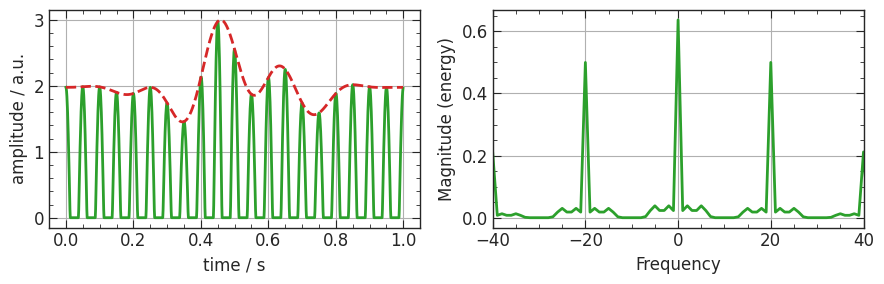

In [6]:
# evelope detection
x_dem = x_am_bp.copy()

# diode
x_dem[x_dem < 0] = 0

# squarer
#x_dem = x_dem**2

n_row = 1
n_col = 2
fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
ax.plot(t, x_dem ,'C2', t, x_am, '--C3');
ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 2)
ax.magnitude_spectrum(x_dem, window=np.ones(x_dem.size), sides="twosided", Fs=sr, scale="linear", color='C2'); # scale="dB" or "linear"
ax.set_xlim(-40, 40)

plt.tight_layout()

### Synchronous detection

A [synchronous detector](https://en.wikipedia.org/wiki/Synchronous_detector) demodulates the bandpass signal by multiplication with an additionally generated carrier signal, which is generated at the receiver. This carrier is frequently called [local oscillator](https://en.wikipedia.org/wiki/Local_oscillator). This multiplication results (similar to the modulation process) in a frequency conversion process, which shifts the bandpass signal back into the baseband (and additionally generates bandpass signals at twice the original carrier frequency.

The disadvantage of a synchronous detector is its sensitivity to frequency or phase missmatch between the carrier signal and the local oscillator, which can be varied in this example.

In order to get rid of these unwanted high frequency components, a [lowpass filter](https://en.wikipedia.org/wiki/Low-pass_filter) can be used afterwards.

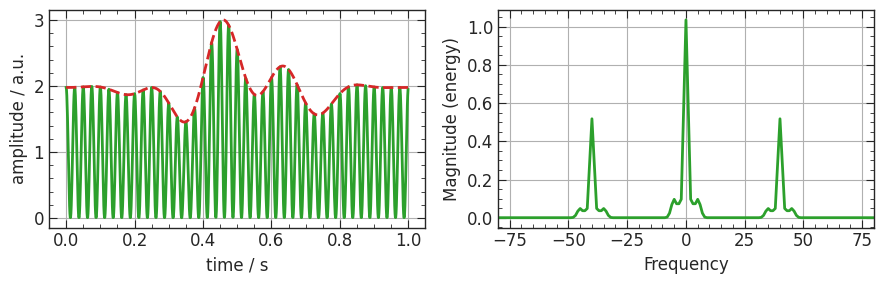

In [7]:
df = 0*10 # frequency offset between LO and carrier
phi_lo = 0*np.pi/2 # phase mismatch between LO and carrier
quadrature = False # use quadrature demodulation?

lo = np.cos(2*np.pi*(fc+df)*t + phi_lo)
x_dem = x_am_bp * lo

if quadrature:
    lo_quadrature = np.sin(2*np.pi*(fc+df)*t + phi_lo)
    x_dem_quadrature = x_am_bp * lo_quadrature


if quadrature:
    n_row = 2
else:
    n_row = 1
n_col = 2

fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
ax.plot(t, x_dem ,'C2', t, x_am, '--C3');
ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 2)
ax.magnitude_spectrum(x_dem, sides="twosided", Fs=sr, scale="linear", color='C2'); # scale="dB" or "linear"
ax.set_xlim(-4*fc, 4*fc);

if quadrature:
    ax = fig.add_subplot(n_row, n_col, 3)
    ax.plot(t, x_dem_quadrature ,'C4', t, x_am, '--C3');
    ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 4)
    ax.magnitude_spectrum(x_dem_quadrature, window=np.ones(x_dem_quadrature.size), sides="twosided", Fs=sr, scale="linear", color='C4'); # scale="dB" or "linear"
    ax.set_xlim(-4*fc, 4*fc)
    
plt.tight_layout()

### Lowpass filtering

In order to remove the unwanted high frequency components generated by the detection process, a [lowpass filter](https://en.wikipedia.org/wiki/Low-pass_filter) is used.

In this example a [Bessel filter](https://en.wikipedia.org/wiki/Bessel_filter) with variable [filter order](???) and [cutoff frequency](https://en.wikipedia.org/wiki/Cutoff_frequency) filter bandwidth is used.

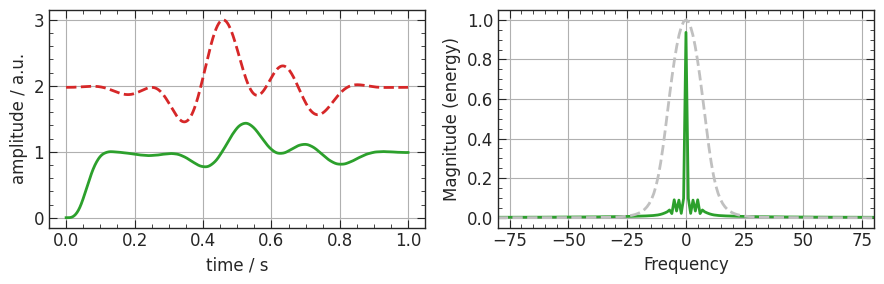

In [8]:
f_cut = 6 # cutoff frequency of lowpass
f_order = 5 # filter order of lowpass

# generate filter coefficients for besselfilter
b, a = signal.bessel(f_order, f_cut, btype='low', analog=False, output='ba', norm='mag', fs=sr)
w, h = signal.freqz(b, a)
w = np.concatenate((np.flip(-w), w))/ 2 / np.pi * sr
h = np.concatenate((np.flip(h), h))

# low pass filter
x_dem_filt = signal.lfilter(b, a, x_dem)

if quadrature:
    x_dem_quadrature_filt = signal.lfilter(b, a, x_dem_quadrature)
    n_row = 2
else:
    n_row = 1
n_col = 2

fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(n_row, n_col, 1)
ax.plot(t, x_dem_filt ,'C2', t, x_am, '--C3');
ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

ax = fig.add_subplot(n_row, n_col, 2)
ax.magnitude_spectrum(x_dem_filt, window=np.ones(x_dem_filt.size), sides="twosided", Fs=sr, scale="linear", color='C2'); # scale="dB" or "linear"
ax.plot(w, np.abs(h), color='silver', ls='dashed')
ax.set_xlim(-4*fc, 4*fc);

if quadrature:
    ax = fig.add_subplot(n_row, n_col, 3)
    ax.plot(t, x_dem_quadrature_filt ,'C4', t, x_am, '--C3');
    ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 4)
    ax.magnitude_spectrum(x_dem_quadrature_filt, window=np.ones(x_dem_quadrature_filt.size), sides="twosided", Fs=sr, scale="linear", color='C4'); # scale="dB" or "linear"
    ax.plot(w, np.abs(h), color='silver', ls='dashed')
    ax.set_xlim(-4*fc, 4*fc)
    
plt.tight_layout()

---

## Ineractive Demo (TODO: CHECK MODULATION INDEX!!!)

Summing up all above principles in order to provide an interactive demo on the amplitude modulation and demodualtion process.

In [9]:
def amplitude_mod(fc = 20, m = 0.5, demod_type="envelope", df=0, phi_lo=0, f_cut = 6, f_order=4, quadrature=False):
    
    fig_height = 5
    
    sr = 1e3    
    t = np.linspace(0, 1-1/sr, int(sr))
    f = np.fft.fftshift(np.fft.fftfreq(np.size(t), 1/sr))
    
    f1 = 5.
    f2 = 2.
    x = (np.sin(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)) * np.blackman(t.size)
    x -= np.mean(x)
    x /= np.max(np.abs(x))
    
    
    c = np.cos(2 * np.pi * fc * t)
    
    maxx = np.max(np.abs(x))
    a = maxx/m
    x_am = a + x

    x_am_bp = x_am * c

    n_row = 1
    n_col = 2
    fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
    fig = plt.figure(figsize=fig_size)
    
    ax = fig.add_subplot(n_row, n_col, 1)
    ax.plot(t, x_am ,'--C3', t, -x_am, '--C3', t, x_am_bp);
    ax.set(xlabel="time / s", ylabel="amplitude / a.u.")
    
    ax = fig.add_subplot(n_row, n_col, 2)
    ax.magnitude_spectrum(x_am_bp, window=np.ones(x_am_bp.size), sides="twosided", Fs=sr, scale="linear"); # scale="dB" or "linear"
    ax.set_xlim(-4*fc, 4*fc)
    
    if demod_type == "envelope":
        # evelope detection
        x_dem = x_am_bp
        # diode
        x_dem[x_dem < 0] = 0
    elif demod_type == "synchron":
        # synchron demodulation        
        lo = np.cos(2*np.pi*(fc+df)*t + phi_lo)
        x_dem = x_am_bp * lo      
        if quadrature:
            lo_quadrature = np.sin(2*np.pi*(fc+df)*t + phi_lo)
            x_dem_quadrature = x_am_bp * lo_quadrature        
    else:
        raise ValueError('demod_type must be either "envelope" or "synchron".')
    
    # generate filter coeffs of digital besselfilter    
    b, a = signal.bessel(f_order, f_cut, btype='low', analog=False, output='ba', norm='mag', fs=sr)
    w, h = signal.freqz(b, a)
    w = np.concatenate((np.flip(-w), w))/ 2 / np.pi * sr
    h = np.concatenate((np.flip(h), h))

    # low pass filter (bessel in this case)
    x_dem_filt = signal.lfilter(b, a, x_dem)    
    if quadrature and (demod_type == "synchron"):
        x_dem_quadrature_filt = signal.lfilter(b, a, x_dem_quadrature)
            

    n_row = 1
    n_col = 2
    fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
    fig = plt.figure(figsize=fig_size)
    
    ax = fig.add_subplot(n_row, n_col, 1)
    ax.plot(t, x_dem_filt ,'C2', t, x_am, '--C3');
    ax.set(xlabel="time / s", ylabel="amplitude / a.u.")
    ax.legend(['demodulated signal', 'information signal'])
    if quadrature and (demod_type == "synchron"):
        ax.plot(t, x_dem_quadrature_filt ,'C4')
        ax.legend(['demod. inphse signal', 'information signal', 'demod. quadrature signal'])
        
    
    ax = fig.add_subplot(n_row, n_col, 2)
    ax.magnitude_spectrum(x_dem_filt, window=np.ones(x_dem_filt.size), sides="twosided", Fs=sr, scale="linear", color='C2'); # scale="dB" or "linear"
    ax.plot(w, np.abs(h), color='silver', ls='dashed')
    ax.set_xlim(-4*fc, 4*fc)
    ax.legend(['demod. inphse signal', 'LP frequency response'])
    if quadrature and (demod_type == "synchron"):
        ax.magnitude_spectrum(x_dem_quadrature_filt, window=np.ones(x_dem_quadrature_filt.size), sides="twosided", Fs=sr, scale="linear", color='C4'); # scale="dB" or "linear"
        ax.legend(['demodulated signal', 'LP frequency response', 'demod. quadrature signal'])
        
    plt.tight_layout()
    
# generate sliders (widgets)
style = {'description_width': '40%'}
w_fc = widgets.IntSlider(min=0, max=400, step=1, value=20, continuous_update=False, description='Carrier freq.:', style=style)
w_m = widgets.FloatSlider(min=0, max=10, step=0.1, value=0.5, continuous_update=False, description='Mod. index:', style=style)
w_f_cut = widgets.IntSlider(min=1, max=400, step=1, value=6, continuous_update=False, description='LP filter cutoff freq.:', style=style)
w_f_order = widgets.IntSlider(min=1, max=10, step=1, value=4, continuous_update=False, description='LP filter order:', style=style)
w_demod_type = widgets.RadioButtons(options=['envelope', 'synchron'], value='envelope', description='Demodulation type:', style=style)
w_df = widgets.FloatSlider(min=0.0, max=20.0, step=0.1, value=0.0, continuous_update=False, description='LO offset freq.:', style=style)
w_phi_lo = widgets.FloatSlider(min=0, max=2*np.pi, step=0.1, value=0.0, continuous_update=False, description='LO phase:', style=style)
w_quadrature = widgets.Checkbox(value=False, description='Quadrature demodulation?', disabled=False)

# group widgets
left_col = widgets.VBox([widgets.Label('General modulation parmeters'), w_fc, w_m])
mid_col = widgets.VBox([widgets.Label('General demodulation parmeters'), w_f_cut, w_f_order, w_demod_type ])
right_col = widgets.VBox([widgets.Label('Synchroneous demodulation parmeters'), w_df, w_phi_lo, w_quadrature])
ui = widgets.HBox([left_col, mid_col, right_col])

# call function (generate output)
out = widgets.interactive_output(amplitude_mod, {'fc':w_fc, 'm':w_m, 'demod_type':w_demod_type, 'df':w_df, 'phi_lo':w_phi_lo, 'f_cut':w_f_cut, 'f_order':w_f_order, 'quadrature':w_quadrature})
out.layout.height = '600px'

# display all
display(ui, out)

Output(layout=Layout(height='600px'))